# Monte Carlo Portfolio Simulation
### The inspiration for doing this project sprouted from a savings habbit that my girlfriend and I adopted, mentioned in the book, Atomic Habbits by James Clear. Every day, instead of choosing to buy lunch, we put the amount of money that we WOULD have spent on lunch into a brokerage account and invest in a broad market index mutual fund. I wanted to show my girlfriend all the possible outcomes. (We cook lunches for the week on Sundays and bring them from home, instead of buying food from cafeteria, fast food, etc.)
### Let's see what daily investing MIGHT do for your portfolio...
#### Brief Background: Monte Carlo is a famous simulation method where many different simulations are run and the results examines. We will first examine the returns of the S&P 500 to determine the distribution of daily return percentages. ONce we have this distribution, we will build a Monte Carlo simulator that applies a random daily return (with a random distribution that closely matches the distribution of S&P 500 returns) and add a new investment each day.


In [233]:
## Import all of the necessary packages to read, clean, analyze and visualize our data
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import random
import time

plt.style.use('ggplot')

### Now that we have all the packages we need imported lets take a closer look at the S&P 500 dataset and create a DataFrame with just the adjusted clos data

In [77]:
## Read raw data from the downloads folder
sp_500 = pd.read_csv(r'C:\Users\dmccloud1\Downloads\^GSPC (1).csv')

## Print first 5 lines
print(sp_500.head())

## Create data frame with just date and adjusted closing value
adj_close = sp_500[['Date','Adj Close']]
#print(adj_close.head()) ## for debugging - prints first 5 rows of new DataFrame

##
adj_close_date = adj_close.set_index(['Date']) # set 'Date' as the index for DataFrame
print(adj_close_date.head()) ## for debugging - prints first 5 rows of new DataFrame

         Date   Open   High    Low  Close  Adj Close   Volume
0  1950-01-03  16.66  16.66  16.66  16.66      16.66  1260000
1  1950-01-04  16.85  16.85  16.85  16.85      16.85  1890000
2  1950-01-05  16.93  16.93  16.93  16.93      16.93  2550000
3  1950-01-06  16.98  16.98  16.98  16.98      16.98  2010000
4  1950-01-09  17.08  17.08  17.08  17.08      17.08  2520000
            Adj Close
Date                 
1950-01-03      16.66
1950-01-04      16.85
1950-01-05      16.93
1950-01-06      16.98
1950-01-09      17.08


### Now that we have our DataFrames containing all S&P500 data and just closing value data, respectively, we can dive further into visually exploring the data to help us model our Monte Carlo simulator. Let's plot a graph to track closing value over time and take a look at the distribution of daily returns


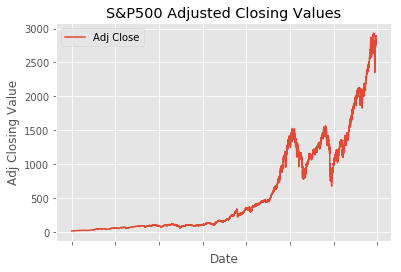

In [112]:
## Plot a line graph to show what the S&P closing value has done over the years

# Create the plot
adj_close.plot(x='DateTime')

# Add title and labels
plt.ylabel('Adj Closing Value')
plt.xlabel('Date')
plt.title('S&P500 Adjusted Closing Values')

# Show the plot
plt.show()


### From this we can see there is a definite trend, but the intraday movements might seem somewhat random, but clearly with a tendancy towards positive returns(hence the direction of this graph). Lets take a look at the distribution of daily returns, as this will serve as a model for the distribution of returns we will use for our Monte Carlo simulator


The largest 1 day positive return is  0.11580036960722695
The largest 1 day negative return is  -0.20466930860972166


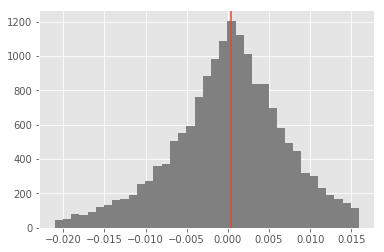

In [161]:
## Plot the daily returns in a historgram to visualize their distribution

# calculate day to day percent change and add this column to the data
adj_close_date['pct_chg'] = adj_close_date.pct_change()

# Lets take a look at the max and min of these to see the range of daily returns
print('The largest 1 day positive return is ',adj_close_date.pct_chg.max())
print('The largest 1 day negative return is ',adj_close_date.pct_chg.min())

# Now that we see the range, lets a create a list for our bins in the historgram
bins = [x + 15.95 for x in np.arange(-37,1)]

# Remember that these are percentages so lets modify our list 
bins = [x/1000 for x in bins]

# plot the distribution
adj_close_date.pct_chg.hist(bins = bins, color= 'gray')
plt.axvline(x=adj_close_date['pct_chg'].mean())




 ### Here we see that the distribution is almost perfectly symmetrical, but has a slight left skew (longer left tail and more values occuring to the right of the mean of the distribution). Now we will need to model our samples return distribution after this. To do that, we will get the counts for each return, those will be the weights of the liklihood that the specific return is drawn at random. We will create a list of these choices and randomly pick form them, and this will be our return for each day.
    

##### Note: The random choice can be generated at each iteration of the monte carlo simulation, but takes a lot of resources and time, that is the reason that the random list is generated first and then interated over)


In [169]:
## Create the 'population' (the returns) and the 'weight' (liklihood of being drawn) 

## first step is to see how many times each return occurs
## This creates a dataframe in which the index is the return and the values are the counts of occurance
return_counts =  pd.DataFrame(adj_close_date.pct_chg.value_counts()).reset_index()
return_counts.head()

## We select the population, or the list of possible returns from the index 
population = return_counts.iloc[:,0]

## We select the weights as the counts of the return's occurance
weights = return_counts.iloc[:,1]

### Now that we have most of the heavy lifting for preparation, we can define a function to call to run our simluation as many times as our heart desires

## Defining a Monte Carlo funcion that will run our simulation as many times as we'd like and give us returns to see what some possible outcomes for out portfolio would be 


In [230]:
## Define a function called monte Carlo
                
## account for a beginning balance, a daily contribution, the number of days and number of trials to be run as inputs to the function
def monte_carlo(beg_val= 0, daily_cont= 50, addl_cont= 0, num_days= 126, num_trials= 1000, dfprint=False):
    start_time = time.time()
    # initiates an empty dataframe used to store each trial (each column will be a trial, rows will be days)

    trials_df = pd.DataFrame()
    
    # loop through the simulatuion as many times as necessary
    for i in range(num_trials):
        # sets initial value of portfolio
        value = beg_val
        # counter for days initilaized at 0
        day_ct = 0
        
        # Days values X
        days = []
        # account Values Y
        acct_values = []
        # sets up list of random return values
        return_list = random.choices(population, weights, k=num_days)
        
        # this loop represents the portfolios change each day
        for x in np.arange(num_days):
            value += daily_cont # increases value by daily contribution amount
            value = value * (1 + return_list[x]) # represents a random day change 
            acct_values.append(value) # adds the value to the list that contains each day's portfolio value
            
        days.append(day_ct)
            
        day_ct += 1
            
        trials_df[i] = acct_values
     ## plots all simluations   
    trials_df.plot(legend= None)
    plt.show()
    
    ## prints some summary statistics and returns a dataframe with all trials
    print('Mean Ending Balance:\t',trials_df.iloc[num_days-1].mean())
    print('Max Ending Balance:\t',trials_df.iloc[num_days-1].max())
    print('Min Ending Balance:\t',trials_df.iloc[num_days-1].min())
    print('This took ', time.time()-start_time, 'seconds to run.')
    
    # a paramater to return dataframe or not
    if dfprint == True:
        return trials_df



#### Now that your function has been defined, call it and pass your own paramaters to see what your portfolio might look like

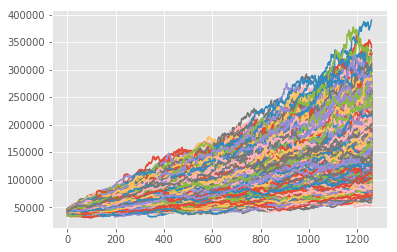

Mean Ending Balance:	 145211.0612231834
Max Ending Balance:	 389781.7991020768
Min Ending Balance:	 53811.89719336223
This took  247.34825491905212 seconds to run.


In [232]:
## running the simulation for 5 year periods, 10,000 times
monte_carlo(beg_val=43000,daily_cont= 50, num_days= 1260, num_trials=10000)

#### Wow! That's a lot of work that gets done relatively quickly. Now lets just check the distribution of returns for our data to make sure it is inline with the S&P500 returns

## Warning! Leaving the parameters in the below code will run for about 25 mins!
#### but that is iterating 12000 random days 10000 times, so still pretty darn quick


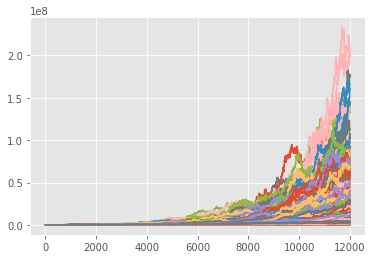

Mean Ending Balance:	 11179391.984944556
Max Ending Balance:	 202308273.34403035
Min Ending Balance:	 402433.56176432833
This took  1508.276756286621 seconds to run.


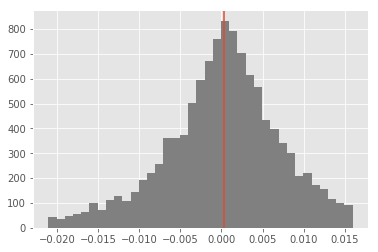

In [231]:
## Check the distribution

# call the function and store datafram in a variable
test_df= monte_carlo(beg_val=43000,daily_cont= 50, num_days= 12000, num_trials=10000, dfprint=True)

# chose a random column(simulation run) 
perc_chg_test = test_df.iloc[:,7]

#and get the pct changes for each day
perc_chg_test['pct_chg'] = perc_chg_test.pct_change()

# plot the distribution of returns
perc_chg_test.pct_chg.hist(bins = bins, color= 'gray')
plt.axvline(x=adj_close_date['pct_chg'].mean())

# Looks pretty close to me! Now go out there and randomly make (or lose) some money! (or lose)